<a href="https://colab.research.google.com/github/RyanbwChien/Fraud_data_LLM_BertModel/blob/main/TIR104_G1_Fraud_Classification_upload.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install transformers
%pip install torch
%pip install onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 25.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [3]:
import torch
torch.__version__

'2.5.1+cu124'

In [4]:
# 技術方法
# 詞袋模型 (Bag-of-Words)
# 詞袋模型將文本文件視為詞語的集合，忽略語法和詞序。它通過計算每個詞在文本中的出現頻率，創建一個數值特徵向量。
# 詞頻-逆文檔頻率 (TF-IDF)
# TF-IDF通過考慮詞在文檔中的出現頻率以及在整個語料庫中的逆頻率，表示詞在文檔中的重要性。
# 詞嵌入 (Word Embedding)
# 詞嵌入技術 (如Word2Vec和GloVe) 將詞表示為高維向量空間中的密集向量，捕捉詞之間的語義關係。
# 機器學習算法
# 可以使用支持向量機 (SVM)、朴素貝葉斯、決策樹等監督學習算法進行文本分類，利用提取的特徵。
# 深度學習模型
# 深度學習模型，如卷積神經網絡 (CNN)、循環神經網絡 (RNN)和基於Transformer的模型 (如BERT)，在文本分類任務中取得了顯著進展。

In [5]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from transformers import AdamW
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
#%% Loader data
import re
import json
def preprocess_text(text):
    text = re.sub(r"<br\s*/?>", ". ", text)  # 或者替换为空格
    text = re.sub(r"\s+", " ", text.strip())  # 清理多余空格 如果有一個以上空白會變成一個空白
    return text
data = pd.read_json(r"/content/drive/MyDrive/Fraud_Model_Dataset.json")
data["Content"] = data["Content"].apply(preprocess_text)

In [7]:
content_len = data["Content"].apply(lambda x:len(x))
content_len_P95 = np.percentile(content_len,95)
print("資料文本長度95%百分位數:",content_len_P95)

retain_content = content_len < content_len_P95
print("移除>1400字的文本共:",len(content_len) - sum(retain_content),"筆")
data = data[retain_content]

資料文本長度95%百分位數: 1391.0
移除>1400字的文本共: 4074 筆


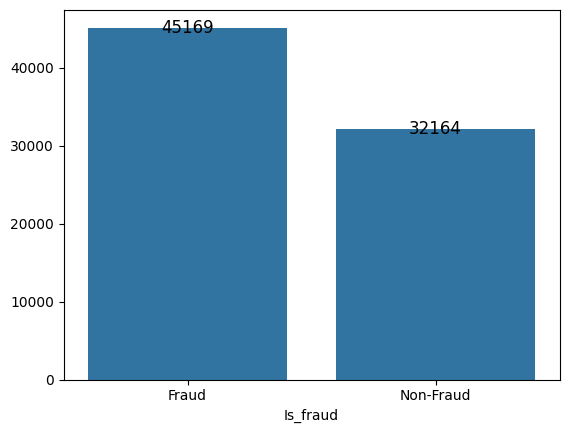

In [8]:
fig, ax = plt.subplots()
label = data["Is_fraud"].apply(lambda x: "Fraud" if x==1 else "Non-Fraud")
counts = label.value_counts()
counts.index
counts.values
sns.barplot(x=counts.index, y=counts.values, ax=ax)

for p in ax.patches:
  height = p.get_height() #返回條形圖的高度
  y = p.get_y() #返回條形圖的底部位置（y 軸起始點）。
  ax.text(p.get_x()+ (p.get_width()/2), p.get_y() + p.get_height(),str(int(p.get_height()))
      ,ha='center',va='center', fontsize=12)

Fraud: 414.0
Non_Fraud: 561.0


<Axes: title={'center': 'Non_Fraud text length Dist.'}, xlabel='Content', ylabel='Count'>

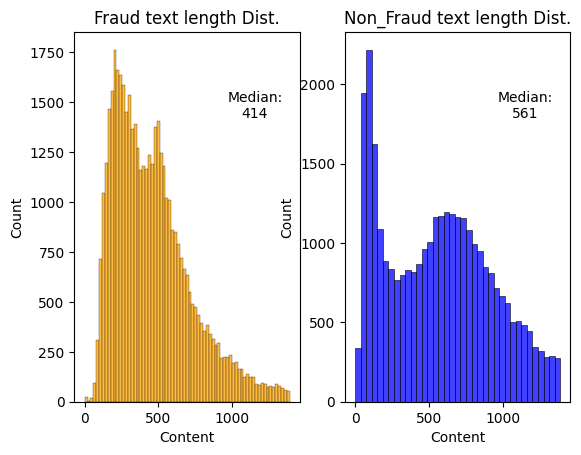

In [9]:
Fraud_len_content = data.query("Is_fraud==1")["Content"].apply(lambda x:len(x))
Non_Fraud_len_content = data.query("Is_fraud==0")["Content"].apply(lambda x:len(x))
print("Fraud:", np.median(Fraud_len_content))
print("Non_Fraud:", np.median(Non_Fraud_len_content))
# np.percentile(len_content,75)
fig, ax = plt.subplots(1,2)
sns.histplot(Fraud_len_content,ax=ax[0],color="orange")
ax[0].set_title("Fraud text length Dist.")
ax[0].text(0.8,0.8, ha='center', va='center',s=f"Median:\n{int(np.median(Fraud_len_content))}", transform=ax[0].transAxes)
ax[1].set_title("Non_Fraud text length Dist.")
ax[1].text(0.8,0.8, ha='center', va='center',s=f"Median:\n{int(np.median(Non_Fraud_len_content))}", transform=ax[1].transAxes)
sns.histplot(Non_Fraud_len_content,ax=ax[1],color="blue")

In [10]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=2)
inputs = tokenizer("你好嗎?", return_tensors="pt") #"pt" means return pytorch tensor
inputs

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'input_ids': tensor([[ 101,  872, 1962, 1621,  136,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [11]:
train, test = train_test_split(data, test_size=0.2, shuffle=True)
train, test = train.reset_index(drop=True), test.reset_index(drop=True)
#將索引重設為從0開始的連續數字，避免原來的索引不連貫，訓練/驗證才不會出錯。

In [12]:
class FraudData(Dataset):
    def __init__(self, data, tokenizer):
        self.X = data["Content"]
        self.Y = data["Is_fraud"]
        self.len = len(self.Y)
        self.tokenizer = tokenizer
    def __len__(self):
        return (self.len)
    def __getitem__(self, index):
        # if index >= self.len:
        #     raise StopAsyncIteration
        # else:
        content = tokenizer(self.X[index], return_tensors="pt", padding="max_length",
                            max_length=512, truncation=True)
        # 這段才是模型內讓文章只取前512字
        labels = self.Y[index]
        return({
            "input_ids": content["input_ids"].squeeze(0), # 讓其便1維度 以便後續dataloader batch
            "attention_mask": content["attention_mask"].squeeze(0),
            "labels": torch.tensor(labels, dtype=torch.long),
        })

Fraud_train = FraudData(train, tokenizer)
Fraud_test = FraudData(test, tokenizer)
len(Fraud_train)

61866

In [13]:
batch_size = 16
dataloader_train = DataLoader(Fraud_train, batch_size=batch_size, shuffle=True)#, shuffle=True # 注意如果DataLoder 前面加iter 會讓之後訓練跑迴圈第一次跑完 全部就變空的，會有異常# dataloader_train = iter(DataLoader(movie_comment_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn))
test_loader = DataLoader(Fraud_test, batch_size=batch_size, shuffle=True)

In [14]:
# 設置設備
# model.to(device) 的具體功能包括：

# 遷移模型的參數與頂點：
# 將模型的重度、偏壓和其他參數從原來的裝置（通常是CPU）移動到目標裝置。
# 支援硬體加速：
# 如果將模型移到GPU（cuda），模型的運算將使用GPU資源，顯著加速訓練和推理。

# 若在 GPU 上進行運算，必須寫 model.to(device)，否則模型默認會在 CPU 上運行。
# 若只使用 CPU，可以不寫 model.to(device)，但仍需確保模型和數據在相同設備上。

device0 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device0)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
epochs = 3
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
for epoch in range(epochs):
    total_loss = 0
    model.train()
    for batch in tqdm(dataloader_train):  # train_loader is your DataLoader tqdm進度條
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device0)
        # print(input_ids.shape ) # torch.Size([16, 512])
        attention_mask = batch["attention_mask"].to(device0)
        labels = batch["labels"].to(device0) #batch["labels"] 是訓練資料中對應每個樣本的正確標籤
        # 使用的是 BertForSequenceClassification，默认使用 CrossEntropyLoss，确保标签是整数格式：
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)#, labels=labels
        logits = outputs.logits
        # print("Logits:", logits) # logits output 是 tensor [batch_size, #labels]
        loss = outputs.loss
        # 反向傳播
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader_train)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.10f}")


100%|██████████| 3562/3562 [19:50<00:00,  2.99it/s]


Epoch 1, Loss: 0.0196788151


100%|██████████| 3562/3562 [19:49<00:00,  2.99it/s]


Epoch 2, Loss: 0.0081035473


100%|██████████| 3562/3562 [19:49<00:00,  2.99it/s]

Epoch 3, Loss: 0.0062123655


In [127]:
# 8. 验证模型
import torch.nn.functional as F
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device0)
        attention_mask = batch["attention_mask"].to(device0)
        labels = batch["labels"].to(device0)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        # logits用来表示模型的原始输出或得分，即未经过 softmax 的得分。
        # 如果需要概率分布，需要手动调用 softmax 函数进行归一化。
        # F.softmax(outputs.logits, dim=1) 将 logits 转换为概率
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

KeyboardInterrupt: 

In [ ]:
# 计算准确率
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9985


In [ ]:
# save whole model
from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/TIR104_G1_Fraud_Classification_text.pth'
# FILE = 'model_all_test_loss0.0485.pt'
torch.save(model, save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# load model
save_path = '/content/drive/MyDrive/TIR104_G1_Fraud_Classification_text.pth'
model2 = torch.load(save_path,map_location=torch.device('cpu') )
model2.to("cpu")

<ipython-input-28-ca02f9114920>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2 = torch.load(save_path,map_location=torch.device('cpu') )


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# device1 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model2.to(device1)

In [81]:
# 初始化 BERT tokenizer
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

# 输入文本列表
fraud = ["【XX銀行通知】您的帳戶存在異常交易，已暫時凍結，請立即點擊以下連結進行身份驗證，以免影響使用！",
"【XX物流】您的包裹因地址錯誤無法派送，請點擊連結確認正確地址，否則將退回發件人。🔗 [連結]",
"【政府補助金通知】恭喜您符合 NT$10,000 疫情補助 申請資格，請點擊以下連結登記領取！🔗 [連結]",
"【限時投資機會】XX 股神內部推薦，高報酬低風險，投資 NT$10,000 獲利 100%！機會有限，立即加入！",
"【緊急通知】您好！我是醫院急診室，您的孩子發生車禍，急需醫療費用 NT$50,000，請立即聯繫我們！📞 [電話]",
"【警方通知】您的身份涉及一宗重大案件，請立即聯繫 XX 警官（電話：[電話]），否則將依法拘捕！",
"【緊急警告】您的銀行卡因異常交易已被鎖定，請立即通過這個鏈接解鎖，否則將無法繼續使用！",
"【限時優惠】恭喜您獲得50%的購物折扣！請點擊下面的鏈接，並輸入您的卡號以便領取您的優惠！",
"【偽造通知】您的信用卡存在欺詐交易，請在10分鐘內點擊鏈接以防止帳戶被凍結！",
"【突發狀況】您的個人資料被泄露，請立即更新您的信息並提供身份證號碼以便保護您的賬戶！"]

non_fraud = [
"【餐廳優惠】感謝您的光臨！今天可以享有全餐8折優惠，請向服務員出示此訊息以享折扣！",
"【Google】您的帳戶設置已成功更新，請確認更改是否正確，並繼續享受我們的服務",
"中華電信恭喜您獲得三星Galaxy S25旗艦系列手機優惠加碼資格，即日起至3/31，憑此簡訊以三星指定機型舊換新，搭配精采5G月繳999元以上方案購買Galaxy S25旗艦系列手機，即享加碼折價最高5,000元，並可同時享有多重中華電信獨家優惠。轉發無效，詳洽123客服。",
"【中華電信通知】截至2/23您尚有2800點未使用，✨推薦抵換「爭鮮餐飲、王品集團、UberEats」連假聚餐首選！https://cht.tw/x/7ugav ✅Hami Point實際點數餘額以系統為準✅[1點=1元 結帳現抵]",
"【健身房通知】感謝您加入我們的健身計劃，您的會員卡已經激活，可以隨時前來運動！",
"【Apple】您的帳戶已成功設置雙重認證，增強了您的帳戶安全性。",
"【亞馬遜】感謝您選擇我們！您的訂單已經處理完畢，預計於明日送達。",
"【Twitter】您的賬戶已啟用新的隱私設置，請檢查設置以確保隱私保護。",
"【報紙訂閱】您的訂閱已成功續訂，謝謝您對我們的支持！",
"【Amazon Prime】恭喜您成功升級為Amazon Prime會員，享受更多專屬福利！"
]

texts = fraud + non_fraud

texts = list(map(lambda x: preprocess_text(x), texts))
all_labels = [1]*10+[0]*10
for i in texts:
  preprocess_text(i)

# 使用 tokenizer 进行标记化并填充
tokens = tokenizer(
    texts,                      # 输入文本
    padding=True,                # 填充样本
    truncation=True,             # 超过 max_length 截断
    max_length=512,              # 最大长度限制
    return_tensors="pt"          # 返回 PyTorch 张量
)

# 输出填充后的数据
input_ids = tokens["input_ids"].to("cpu")    # Token IDs shape: (batch_size, seq_length)
attention_mask = tokens["attention_mask"].to("cpu")  # Attention mask shape: (batch_size, seq_length)
# outputs = model(**inputs)

In [82]:
import torch.nn.functional as F
model2.eval()
outputs = model2(input_ids, attention_mask=attention_mask)
logits = outputs.logits

預測值 [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1]
預測值 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Validation Accuracy: 0.80
Recall Rate: 0.90
Precision: 0.75
F1 Score: 0.82


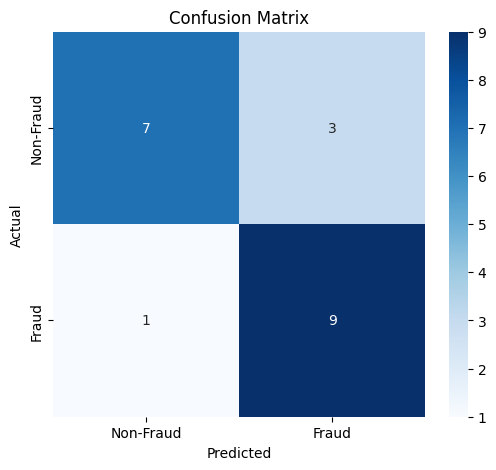

In [87]:
all_preds = torch.argmax(logits, dim=-1)
Fraun_prob = F.softmax(logits,dim=-1)[:,1]
print("預測值",all_preds.tolist())
print("預測值",all_labels)
# print("預測詐騙機率",[round(i,2) for i in Fraun_prob.tolist()])
# 计算准确率
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, classification_report
accuracy = accuracy_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Recall Rate: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
# 计算混淆矩阵
cm = confusion_matrix(y_true=all_labels, y_pred=all_preds)
# 绘制混淆矩阵热力图
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()